**Install packages**

In [1]:
!pip install tensorflow==2.15.0

**Import libraries**

In [2]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

import pickle
import numpy as np
import copy
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

from google.colab import files
import shutil
import os

**Mount drive**

In [3]:
from google.colab import drive
import os

drive.mount('/content/drive')
root_path = '/content/drive/MyDrive/Aprendizado de máquina/Trabalho 1 - Clonagem comportamental'   # Script location
os.chdir(root_path)

Mounted at /content/drive


**Load datapoints**

In [4]:
all_datapoints = []

for file in os.listdir('dataset'):
    if 'alt' in file:
        with open('dataset/'+file, 'rb') as f:
            datapoints = pickle.load(f)
            all_datapoints.extend(datapoints)

In [5]:
x = np.array([data[0] for data in all_datapoints])
y = np.array([data[1] for data in all_datapoints])

del all_datapoints

**See some data**

array([[[100, 100, 100],
        [100, 100, 100],
        [102, 102, 102],
        ...,
        [100, 202, 100],
        [100, 202, 100],
        [100, 202, 100]],

       [[100, 100, 100],
        [100, 100, 100],
        [103, 103, 103],
        ...,
        [100, 202, 100],
        [100, 202, 100],
        [100, 202, 100]],

       [[100, 100, 100],
        [100, 100, 100],
        [104, 104, 104],
        ...,
        [100, 202, 100],
        [100, 202, 100],
        [100, 202, 100]],

       ...,

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]]], dtype=uint8)
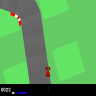

In [6]:
x[130]

In [7]:
y[130]

array([0.00899731, 0.        , 0.00339885])

**Train/test split**

In [8]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=True, random_state=1)

x_train_norm = x_train/float(255)
x_test_norm = x_test/float(255)

y_train_norm = copy.deepcopy(y_train)
y_train_norm[:, 0] = (y_train_norm[:, 0] + 1) / 2

y_test_norm = copy.deepcopy(y_test)
y_test_norm[:, 0] = (y_test_norm[:, 0] + 1) / 2

del x
del y

**Build model**

In [9]:
def create_model(input_shape, dropout_rate):
    input_layer = tf.keras.layers.Input(shape=input_shape)

    conv1 = tf.keras.layers.Conv2D(16, (7, 7), strides=(1, 1), activation='relu')(input_layer)

    conv2 = tf.keras.layers.Conv2D(32, (5, 5), strides=(2, 2), activation='relu')(conv1)

    conv3 = tf.keras.layers.Conv2D(64, (3, 3), strides=(2, 2), activation='relu')(conv2)

    conv4 = tf.keras.layers.Conv2D(64, (3, 3), strides=(2, 2), activation='relu')(conv3)

    conv5 = tf.keras.layers.Conv2D(128, (3, 3), strides=(2, 2), activation='relu')(conv4)

    conv6 = tf.keras.layers.Conv2D(128, (3, 3), strides=(2, 2), activation='relu')(conv5)

    flatten = tf.keras.layers.Flatten()(conv6)

    hidden = tf.keras.layers.Dense(16, activation='relu')(flatten)

    dropout = tf.keras.layers.Dropout(dropout_rate)(hidden)

    output_layer = tf.keras.layers.Dense(3, activation='sigmoid')(dropout)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

    return model

**Callback to save the best model**

In [10]:
class SaveBestModel(tf.keras.callbacks.Callback):
    def __init__(self, save_best_metric='val_loss', this_max=False):
        self.save_best_metric = save_best_metric
        self.max = this_max
        if this_max:
            self.best = float('-inf')
        else:
            self.best = float('inf')

    def on_epoch_end(self, epoch, logs=None):
        metric_value = logs[self.save_best_metric]
        if self.max:
            if metric_value > self.best:
                self.best = metric_value
                self.best_weights = self.model.get_weights()

        else:
            if metric_value < self.best:
                self.best = metric_value
                self.best_weights= self.model.get_weights()

**Initialize model**

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 90, 90, 16)        2368      
                                                                 
 conv2d_7 (Conv2D)           (None, 43, 43, 32)        12832     
                                                                 
 conv2d_8 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 conv2d_9 (Conv2D)           (None, 10, 10, 64)        36928     
                                                                 
 conv2d_10 (Conv2D)          (None, 4, 4, 128)         73856     
                                                                 
 conv2d_11 (Conv2D)          (None, 1, 1, 128)         1475

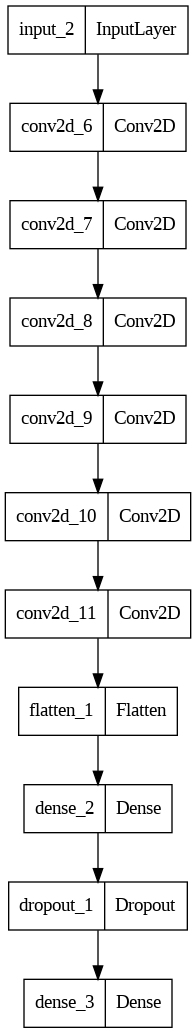

In [20]:
input_shape = (96, 96, 3)
dropout_rate = 0.2

model = create_model(input_shape, dropout_rate)

model.summary()
tf.keras.utils.plot_model(model)

**Compile model**

In [21]:
init_lr = 0.0001

optimizer = tf.keras.optimizers.experimental.Adam(learning_rate=init_lr)
loss = tf.keras.losses.MeanSquaredError()

save_best_model = SaveBestModel(save_best_metric='val_loss')
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5),
             save_best_model]

model.compile(optimizer=optimizer, loss=loss)

**Train model**

In [22]:
bs = 16
epochs = 80

history = model.fit(x_train_norm, y_train_norm,
                    validation_data=(x_test_norm,y_test_norm),
                    epochs=epochs,
                    batch_size=bs,
                    callbacks=callbacks)

Epoch 1/80
  2/299 [..............................] - ETA: 2:30 - loss: 0.1776 

299/299 [==============================] - 8s 16ms/step - loss: 0.0583 - val_loss: 0.0262
Epoch 2/80
299/299 [==============================] - 3s 9ms/step - loss: 0.0448 - val_loss: 0.0229
Epoch 3/80
299/299 [==============================] - 3s 12ms/step - loss: 0.0406 - val_loss: 0.0217
Epoch 4/80
299/299 [==============================] - 3s 9ms/step - loss: 0.0364 - val_loss: 0.0215
Epoch 5/80
299/299 [==============================] - 3s 9ms/step - loss: 0.0344 - val_loss: 0.0206
Epoch 6/80
299/299 [==============================] - 3s 9ms/step - loss: 0.0330 - val_loss: 0.0200
Epoch 7/80
299/299 [==============================] - 2s 7ms/step - loss: 0.0308 - val_loss: 0.0204
Epoch 8/80
299/299 [==============================] - 2s 7ms/step - loss: 0.0299 - val_loss: 0.0204
Epoch 9/80
299/299 [==============================] - 2s 7ms/step - loss: 0.0284 - val_loss: 0.0198
Epoch 10/80
299/299 [==============================] - 4s 12ms/step - loss: 0.0277 - val_loss: 0.0195
Epoch 1

**Get weigths from the best model (optional)**

In [23]:
model.set_weights(save_best_model.best_weights)
print(save_best_model.best)

0.0127176558598876


**Training results**

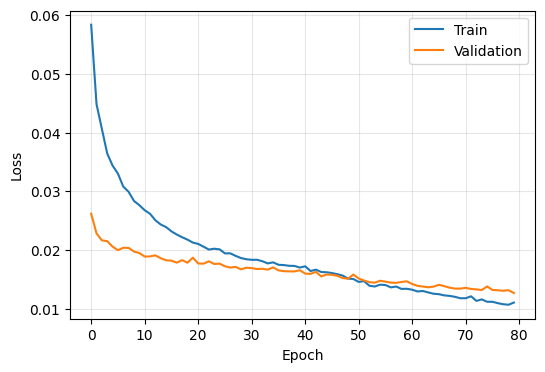

In [24]:
plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

plt.grid(True, alpha=0.3)
plt.show()

**Save model**

In [25]:
model.save('models/model_alt')

**Load and test model**

In [26]:
loaded_model = tf.keras.models.load_model('models/model_alt')

array([[[100, 202, 100],
        [100, 202, 100],
        [100, 202, 100],
        ...,
        [100, 202, 100],
        [100, 202, 100],
        [100, 202, 100]],

       [[100, 202, 100],
        [100, 202, 100],
        [100, 202, 100],
        ...,
        [100, 202, 100],
        [100, 202, 100],
        [100, 202, 100]],

       [[100, 202, 100],
        [100, 202, 100],
        [100, 202, 100],
        ...,
        [100, 202, 100],
        [100, 202, 100],
        [100, 202, 100]],

       ...,

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]]], dtype=uint8)
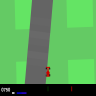

In [27]:
x_test[100]

In [28]:
loaded_model.predict(np.array([x_test_norm[100]]), verbose=0)

array([[4.9119464e-01, 2.5117889e-04, 4.9778741e-06]], dtype=float32)